In [74]:
from __future__ import print_function, division
from math import *
from xmlparser import *
from statutils import *
import random
import sys
import matplotlib.pyplot as plt




__author__ = "devan, jordy, arjun"

In [75]:
# Few Utility functions
def say(*lst):
    """
    Print whithout going to new line
    """
    print(*lst, end="")
    sys.stdout.flush()

def random_value(low, high, decimals=2):
    """
    Generate a random number between low and high. 
    decimals incidicate number of decimal places
    """
    return round(random.uniform(low, high),decimals)

def gt(a, b): return a > b

def lt(a, b): return a < b

def shuffle(lst):
    """
    Shuffle a list
    """
    random.shuffle(lst)
    return lst

In [76]:
class O:
    def __init__(self, **kwargs):
        self.has().update(**kwargs)
    def has(self):
        return self.__dict__
    def update(self, **kwargs):
        self.has().update(kwargs)
        return self
    def __repr__(self):
        show = [':%s %s' % (k, self.has()[k]) 
                for k in sorted(self.has().keys()) 
                if k[0] is not "_"]
        txt = ' '.join(show)
        if len(txt) > 60:
            show = map(lambda x: '\t' + x + '\n', show)
        return '{' + ' '.join(show) + '}'

In [77]:
class Decision(O):
    def __init__(self, name, present=False):
        O.__init__(self, name=name, present=present)

In [78]:
class Objective(O):
    #need to think of more objectives
    def __init__(self, name, low=0, high=1, do_minimize=True):
        O.__init__(self, name=name, do_minimize=do_minimize, low=low, high=high)
        
    def normalize(self, val):
        return (val - self.low)/(self.high - self.low)

In [79]:
class Point(O):
    def __init__(self, decisions):
        O.__init__(self)
        self.decisions = decisions
        self.objectives = None
        
    def __hash__(self):
        return hash(tuple(self.decisions))
    
    def __eq__(self, other):
        return self.decisions == other.decisions
    
    def clone(self):
        new = Point(self.decisions[:])
        new.objectives = self.objectives[:]
        return new

In [80]:
class Problem(O):
    def __init__(self, xml, BUDGET):
        O.__init__(self)
        #parse and make the feature tree and the constraint repository
        self.model_name = xml.split('.')[0]
        parser = XmlParser()
        self.tree = parser.parseFeatureTree(xml)
        self.constraintrepo = parser.parseConstraints(xml)
        
        #populate the feature map and the evaluation order
        self.feature_map = self.tree.feature_map
        self.evaluation_order = [x for x in self.feature_map.values()]
        self.evaluation_order.sort(key=lambda x : len(x.id.split("_")), reverse = True)
        
        #Fill in the decisions list and assign the cost of the features
        self.decisions = self.tree.getLeaves()
        for leaf in self.decisions:
            leaf.cost=random.randint(100,1000)
        
        #print([x.cost for x in self.decisions])
        
        #Fill in the objectives list and their boundary values
        self.objectives=[]
        self.objectives.append(Objective("constraint_violations", 0, len(self.constraintrepo.constraints)))
        self.objectives.append(Objective("#offeatures", 0, len(self.feature_map), do_minimize = False))
        self.objectives.append(Objective("cost_of_implementation", 0, BUDGET))
        #Add more objectives
    
    def details(self):
        print(self.model_name)
        print('Number of decisions : ', len(self.decisions))
        print('Number of Features : ',len(self.feature_map))
              
    def cleanTree(self):
        for x in self.feature_map.values():
            if not x.isLeaf():
                x.cost=0
                self.constraintrepo.setFlag(x.id, False)
                x.present = False
                
    
    def evaluate(self, point):
        if not point.objectives:
            
            violations = 0
            features = 0
            cost = 0
            
            for i,boo in enumerate(point.decisions):
                self.constraintrepo.setFlag(self.decisions[i].id, boo)
                self.decisions[i].present=boo
                
            #For all non leaf nodes calculate the cost and present/absent value
            self.cleanTree()
            for node in self.evaluation_order:
                parent = node.parent
                if parent is None:
                    continue
                if node.present:
                    parent.present=True
                    self.constraintrepo.setFlag(parent.id, True)
                    parent.cost+=node.cost
                
            #get the number of violations
            violations = self.constraintrepo.getNumOfConstraintsViolated()
            
            #get the number of features supported
            for x in self.feature_map.values():
                if x.present:
                    features+=1
            #get the total cost
            cost = self.tree.root.cost
            
            point.objectives=[violations, features, cost]
        #print('in',point.objectives)
        return point.objectives
    
    @staticmethod
    def is_valid(point):
        #We assume all points are valid
        return True
    def generate_one(self, retries = 20):
        for _ in xrange(retries):
            point = Point([random.random()>0.5 for _ in self.decisions])
            if self.is_valid(point):
                return point
        raise RuntimeError("Exceeded max runtimes of %d" % 20)


#pr = Problem('eCommerce.xml', 10000)
#one = pr.generate_one()
#two = pr.generate_one()
#three = pr.generate_one()
#print(one.decisions)
#print(two.decisions)
#print(three.decisions)
#pr.evaluate(one)
#pr.evaluate(two)
#pr.evaluate(three)

In [81]:
def populate(problem, size):
    population = []
    for _ in range(size):
        population.append(problem.generate_one())
    return population

def crossover(mom, dad):
    n = len(mom.decisions)
    return Point(mom.decisions[:n//2] + dad.decisions[n//2:])

def mutate(problem, point, mutation_rate=0.01):
    for i, decision in enumerate(problem.decisions):
        if random.random() < mutation_rate:
            point.decisions[i] = random.random()>0.5
    return point

def cdom(problem, one, two):

    def loss(x, y):
        losses= 0
        n = min(len(x),len(y))
        for i,(x1,y1) in enumerate(zip(x,y)):
            x1 = problem.objectives[i].normalize(x1) # normalization
            y1 = problem.objectives[i].normalize(y1) # normalization
            dir = -1 if problem.objectives[i].do_minimize else 1 # adjust for direction of comparison
            losses += -1*e**(dir*(x1 - y1) / n) # raise the differences to some exponent
        return losses / n  # return mean loss
    
    x = problem.evaluate(one)
    y = problem.evaluate(two)
    lxy, lyx = loss(x, y), loss(y, x)
    return lxy < lyx

def bdom(problem, one, two):
    objs_one = problem.evaluate(one)
    objs_two = problem.evaluate(two)
    dominates = False
    for i, obj in enumerate(problem.objectives):
        better = lt if obj.do_minimize else gt
        if better(objs_one[i], objs_two[i]):
            dominates = True
        elif objs_one[i] != objs_two[i]:
            return False
    return dominates

def fitness(problem, population, point, dom_func):
    return len([1 for another in population if dom_func(problem, point, another)])

def elitism(problem, population, retain_size, dom_func):
    fitnesses = []
    for point in population:
        fitnesses.append((fitness(problem, population, point, dom_func), point))
    population = [tup[1] for tup in sorted(fitnesses, reverse=True)]
    return population[:retain_size]

def rank2(problem, population, point, dom_func):
    return len([1 for another in population if dom_func(problem, another, point)])

def dominates2(problem, population, point, dom_func):
    return [x for x in population if dom_func(problem, point, x)]
#problem = Problem('Linux.xml', 10000)
#population = populate(problem, 100)
#print(population)
#po=[problem.evaluate(point) for point in population]
#print(po)

problem=Problem('Linux.xml', 10000)
one=problem.generate_one()
two=problem.generate_one()
print(problem.evaluate(one), problem.evaluate(two))
print(cdom(problem, one,two))

[2, 28, 7109] [2, 32, 7405]
False


In [82]:
def elitism2(problem, population, retain_size, dom_func):
    #print(population)
    #print('************************************************')
    point_ranks = dict()
    downstream = dict()
    selected=[]
    for point in population:
        point_ranks[point]=rank2(problem, population, point, dom_func)
        downstream[point]=dominates2(problem, population, point, dom_func)
    zero_ranked=[]
    while(retain_size>0):
        for x in point_ranks:
            if point_ranks[x]==0:
                zero_ranked.append(x)
                point_ranks[x]-=1
        for x in zero_ranked:
            for y in downstream[x]:
                point_ranks[y]-=1
                
        if len(zero_ranked)<=retain_size:
            retain_size-=len(zero_ranked)
            selected.extend(zero_ranked)
            #print(zero_ranked)
            zero_ranked[:]=[]
            #print(zero_ranked)
            #print(zero_ranked)
        else:
            fitnesses=[]
            for point in zero_ranked:
                fitnesses.append((fitness(problem, zero_ranked, point, dom_func), point))
            zero_ranked = [tup[1] for tup in sorted(fitnesses, reverse=True)]
            selected.extend(zero_ranked[:retain_size])
            retain_size=0
        
    return selected

#problem = Problem('Linux.xml', 10000)
#population = populate(problem, 100)
#elitism2(problem, population, 100, cdom)

In [83]:
def avg_and_variance(populations):
    size_=len(populations)
    obj_list = [p.objectives for p in populations]
    avgs = [sum([i[0] for i in obj_list])/size_,
            sum([i[1] for i in obj_list])/size_, 
            sum([i[2] for i in obj_list])/size_]

    variances = [sum((i[0]-avgs[0]) * (i[0]-avgs[0]) for i in obj_list)/size_, 
                 sum((i[1]-avgs[1]) * (i[1]-avgs[1]) for i in obj_list)/size_, 
                 sum((i[2]-avgs[2]) * (i[2]-avgs[2]) for i in obj_list)/size_]
    print(avgs)
    print(variances)
    return avgs, variances

In [84]:
def ga(problem, pop_size = 100, gens = 250, dom_func=bdom):
    population = populate(problem, pop_size)
    #print(population)
    po=[problem.evaluate(point) for point in population]
    #print(po)
    initial_population = [point.clone() for point in population]
    gen = 0 
    while gen < gens:
        say(".")
        children = []
        for _ in range(pop_size):
            mom = random.choice(population)
            dad = random.choice(population)
            while (mom == dad):
                dad = random.choice(population)
            child = mutate(problem, crossover(mom, dad))
            if problem.is_valid(child) and child not in population+children:
                children.append(child)
        population += children
        population = elitism(problem, population, pop_size, dom_func)
        gen += 1
    print("")
    return initial_population, population

#ga(problem, pop_size=100, gens=250, dom_func=cdom)

In [85]:
def nsga2(problem, pop_size = 100, gens = 250, dom_func=bdom):
    population = populate(problem, pop_size)
    po=[problem.evaluate(point) for point in population]
    #print(po)
    initial_population = [point.clone() for point in population]
    gen = 0 
    while gen < gens:
        say(".")
        children = []
        for _ in range(pop_size):
            mom = random.choice(population)
            dad = random.choice(population)
            while (mom == dad):
                dad = random.choice(population)
            child = mutate(problem, crossover(mom, dad))
            if problem.is_valid(child) and child not in population+children:
                children.append(child)
        population += children
        population = elitism2(problem, population, pop_size, dom_func)
        gen += 1
    print("")
    return initial_population, population

#nsga2(problem, pop_size=100, gens=5, dom_func=cdom)

In [86]:
def plot_pareto(initial, final):
    initial_objs = [point.objectives for point in initial]
    final_objs = [point.objectives for point in final]
    initial_x = [i[0] for i in initial_objs]
    initial_y = [i[1] for i in initial_objs]
    initial_z = [i[2] for i in initial_objs]
    
    final_x = [i[0] for i in final_objs]
    final_y = [i[1] for i in final_objs]
    final_z = [i[2] for i in final_objs]
    
    plt.scatter(initial_x, initial_y, color='b', marker='+', label='initial')
    plt.scatter(final_x, final_y, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.ylabel("Implemented Features")
    plt.xlabel("Constraints Violated")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    
    plt.scatter(initial_z, initial_y, color='b', marker='+', label='initial')
    plt.scatter(final_z, final_y, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.xlabel("Cost of Implementation")
    plt.ylabel("Implemented Features")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    
    plt.scatter(initial_x, initial_z, color='b', marker='+', label='initial')
    plt.scatter(final_x, final_z, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.ylabel("Cost of Implementation")
    plt.xlabel("Constraints Violated")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    

In [87]:
def plot_3D(initial, final, initialObjectives=None, finalObjectives=None):
    
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    if initialObjectives is None:
        initial_objs = [point.objectives for point in initial]
    else:
        initial_objs = initialObjectives
    if finalObjectives is None:
        final_objs = [point.objectives for point in final]
    else:
        final_objs = finalObjectives
    
    initial_x = [i[0] for i in initial_objs]
    initial_y = [i[1] for i in initial_objs]
    initial_z = [i[2] for i in initial_objs]
    
    final_x = [i[0] for i in final_objs]
    final_y = [i[1] for i in final_objs]
    final_z = [i[2] for i in final_objs]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    n = 100
    
    ax.scatter(initial_x, initial_z, initial_y, c='r', marker='o')
    ax.scatter(final_x, final_z, final_y, c='b', marker='^')

    
    ax.set_xlabel('Constraints Violated')
    ax.set_ylabel('Cost of Implementation')
    ax.set_zlabel('Supported Features')

    plt.show()

In [88]:
#Comparison of various algorithms
#For this we need the objectives to be normalized
def normalize(problem, points):
    """
    Normalize all the objectives
    in each point and return them
    """
    meta = problem.objectives
    all_objs = []
    for point in points:
        objs = []
        for i, o in enumerate(problem.evaluate(point)):
            low, high = meta[i].low, meta[i].high
            if high == low: objs.append(0);continue;
            objs.append((o-low)/(high-low))
    # TODO 3: Normalize 'o' between 'low' and 'high'; Then add the normalized value to 'objs'
        all_objs.append(objs)
    return all_objs

In [89]:
def make_reference(problem, *fronts):
    retain_size = len(fronts[0])
    reference = []
    for front in fronts:
        reference+=front
    fitnesses = []
    
    def bdom(one, two):
        dominates = False
        for i, obj in enumerate(problem.objectives):
            better = lt if obj.do_minimize else gt
            if better(one[i], two[i]):
                dominates = True
            elif one[i]!=two[i]:
                return False
        return dominates
  
    def fitness(one, dom_func):
        return len([1 for another in reference if dom_func(one, another)])

    for point in reference:
        fitnesses.append((fitness(point, bdom), point))
        
    reference = [tup[1] for tup in sorted(fitnesses, reverse=True)]
    return reference[:retain_size]

In [90]:
def eucledian(one, two):
    return (sum([(o-t)**2 for o,t in zip(one, two)]) / len(one))**.5

def sort_solutions(solutions):
    def sorter(lst):
        m = len(lst)
        weights = reversed([10 ** i for i in xrange(m)])
        return sum([element * weight for element, weight in zip(lst, weights)])
    return sorted(solutions, key=sorter)


def closest(one, many):
    min_dist = sys.maxint
    closest_point = None
    for this in many:
        dist = eucledian(this, one)
        if dist < min_dist:
            min_dist = dist
            closest_point = this
    return min_dist, closest_point

def spread(obtained, ideals):
    s_obtained = sort_solutions(obtained)
    s_ideals = sort_solutions(ideals)
    d_f = closest(s_ideals[0], s_obtained)[0]
    d_l = closest(s_ideals[-1], s_obtained)[0]
    n = len(s_ideals)
    distances = []
    for i in range(len(s_obtained)-1):
        distances.append(eucledian(s_obtained[i], s_obtained[i+1]))
    d_bar = sum(distances)/len(distances)
    d_sum = sum([abs(d_i - d_bar)for d_i in distances])
    delta = (d_f + d_l + d_sum) /(d_f + d_l + (n-1)*d_bar)
    return delta

In [91]:
def igd(obtained, ideals):
    igd_val = sum([closest(ideal, obtained)[0] for ideal in ideals])/len(ideals)
    return igd_val

In [92]:
#Augustine's Hypervolume code goes here

In [93]:
def format_for_stats(problem, data, measure):
    
    gens = data.keys()
    print(gens)
    
    #print(data[gens[0]])
    reps = len(data[gens[0]])
    measured = {gen:[gen] for gen in gens}
    for i in range(reps):
        ref_args = [data[gen][i] for gen in gens]
        ref = make_reference(problem, *ref_args)
        for gen in gens:
            measured[gen].append(measure(data[gen][i], ref))
    return measured

def report(problem, tests, measure):
    measured = format_for_stats(problem, tests, measure).values()
    #print(measured)
    rdivDemo(measured)

enterprisesys
Number of decisions :  342
Number of Features :  385
Running  nsga2
..................................................


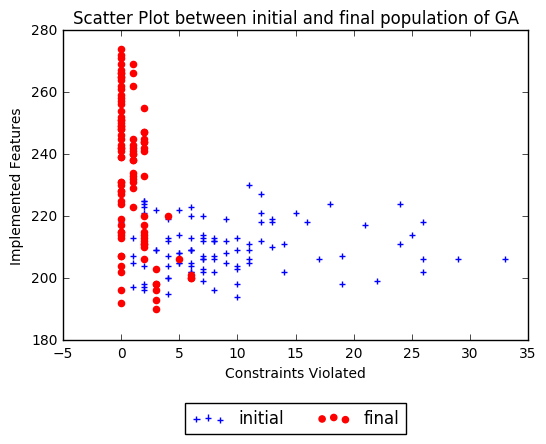

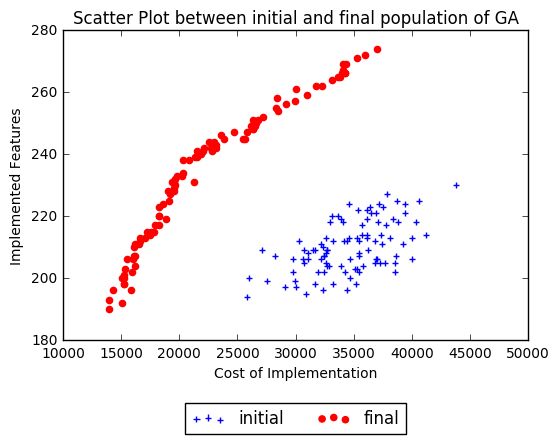

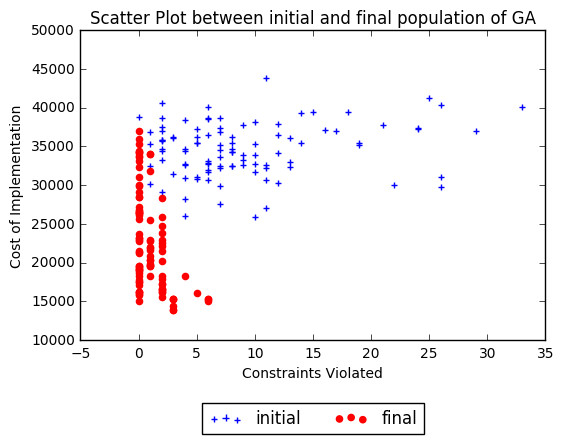

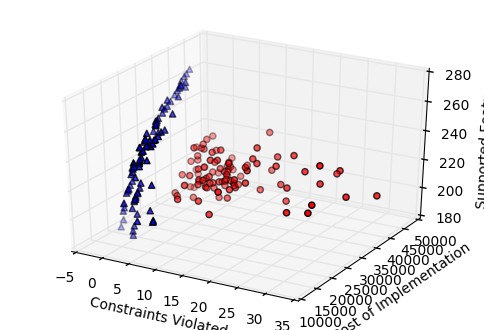

Running  ga
..................................................


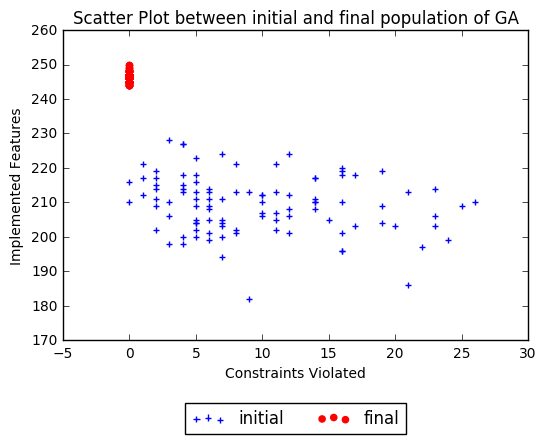

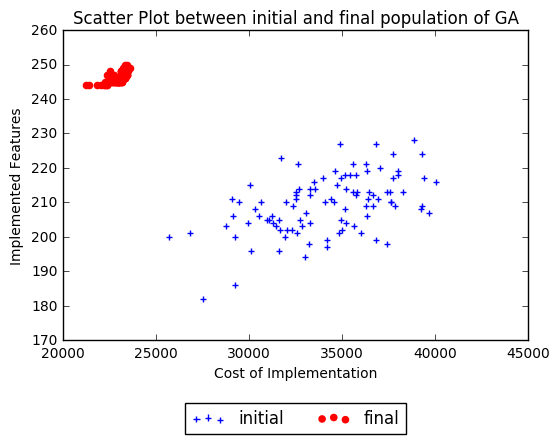

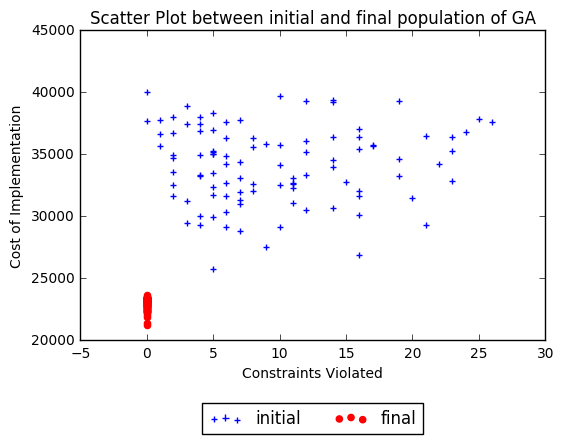

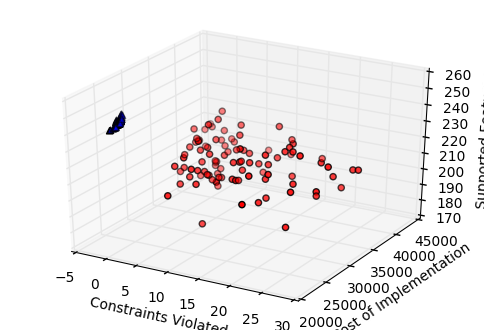

Running  nsga2
..................................................


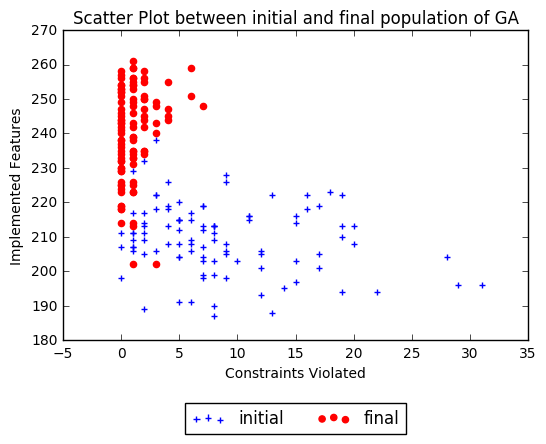

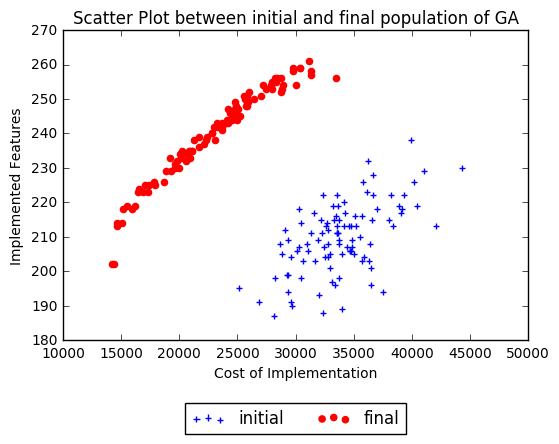

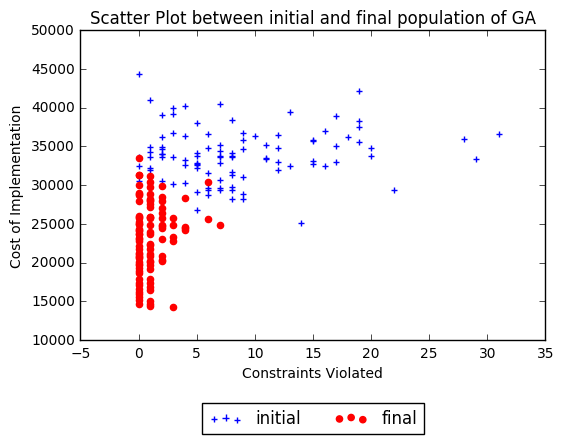

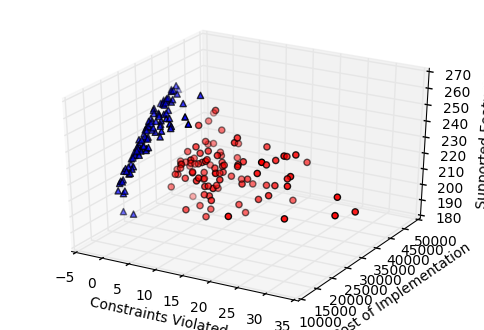

Running  ga
..................................................


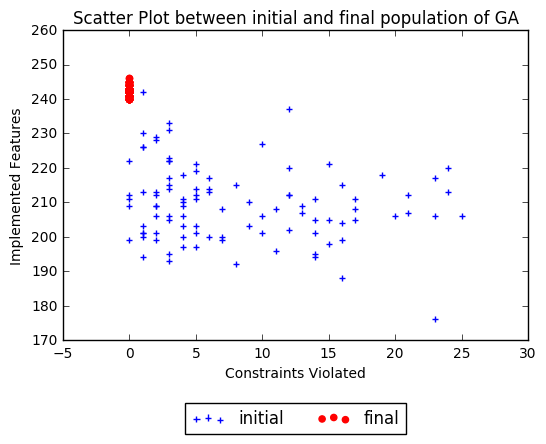

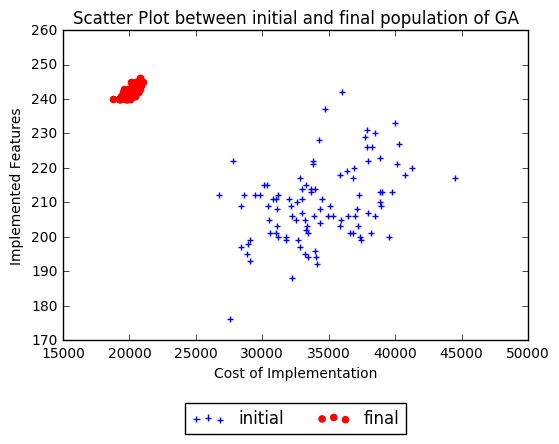

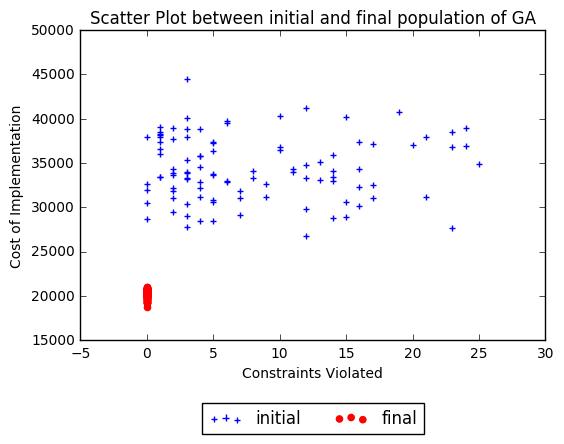

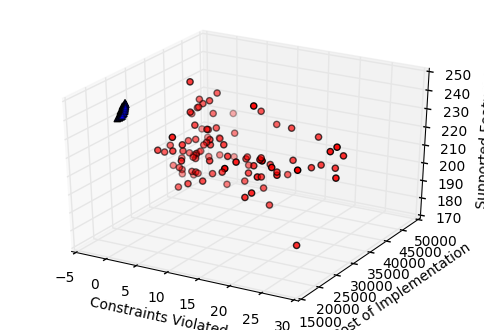

Running  nsga2
..................................................


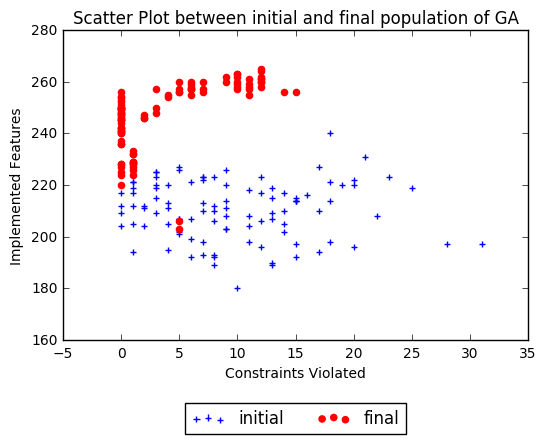

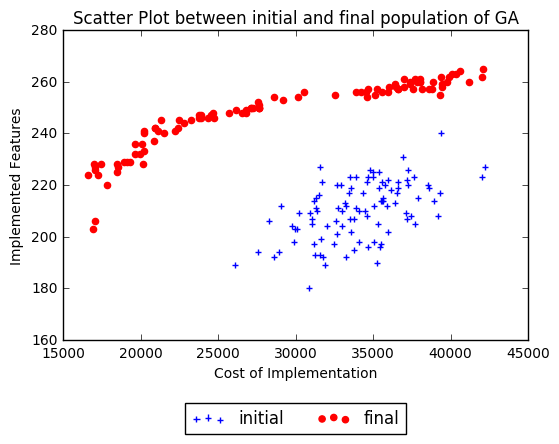

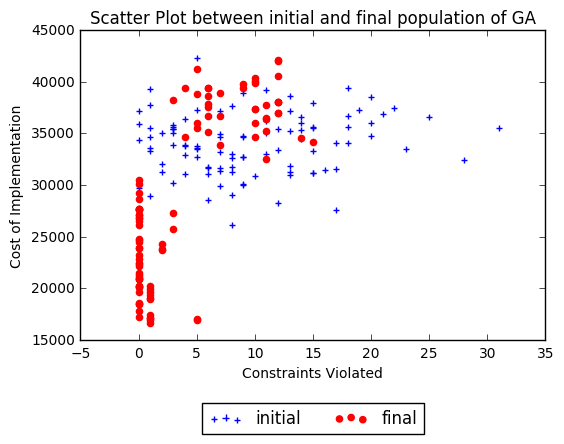

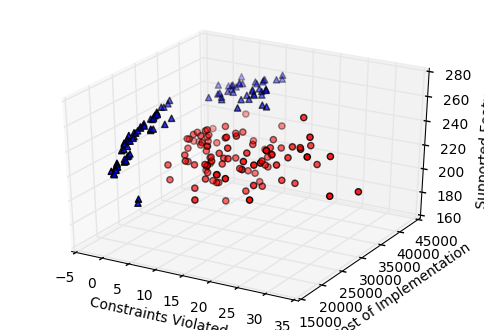

Running  ga
..................................................


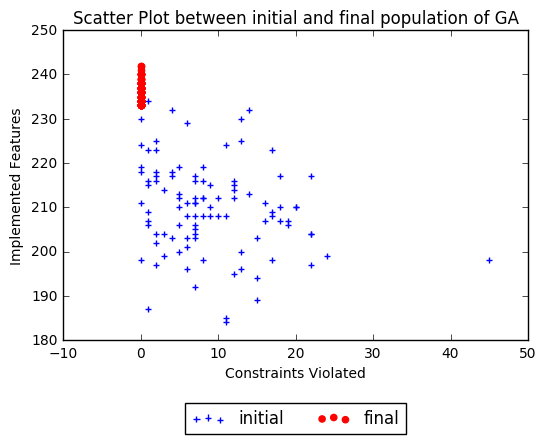

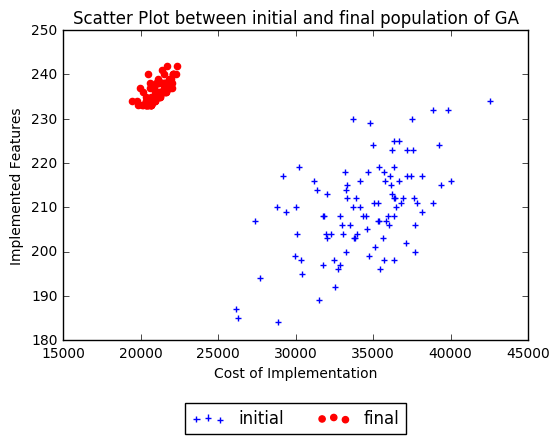

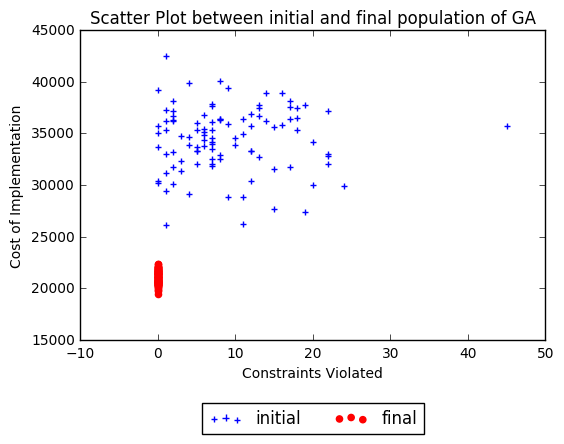

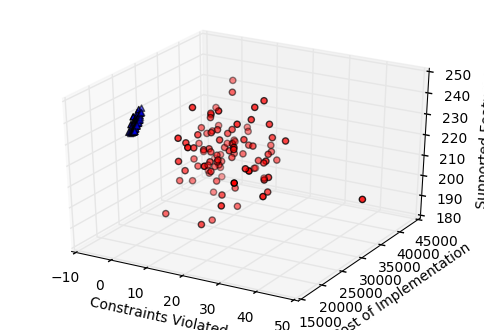

Running  nsga2
..................................................


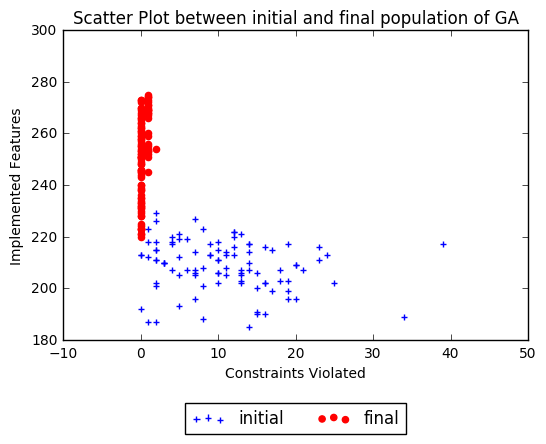

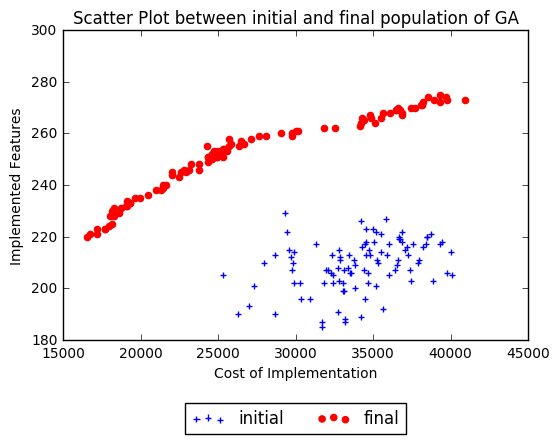

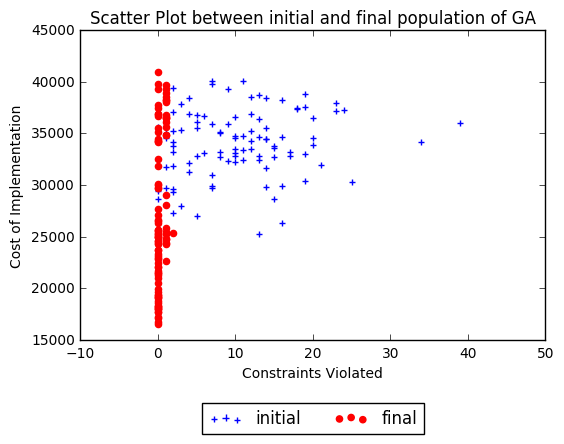

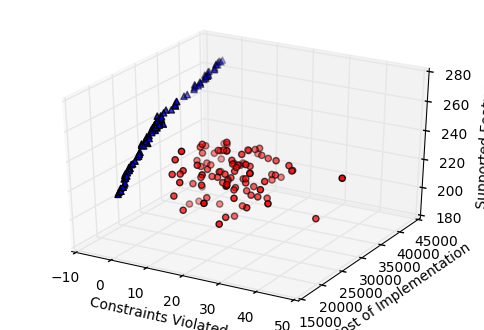

Running  ga
..................................................


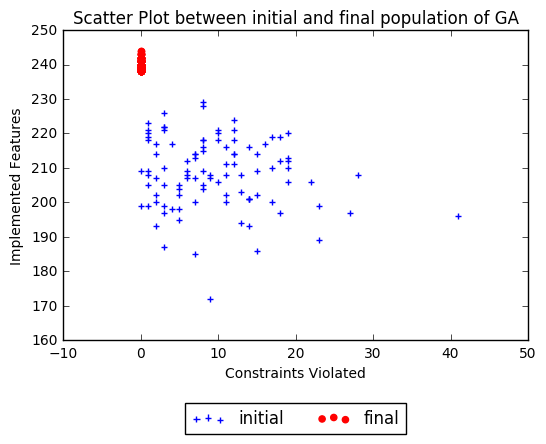

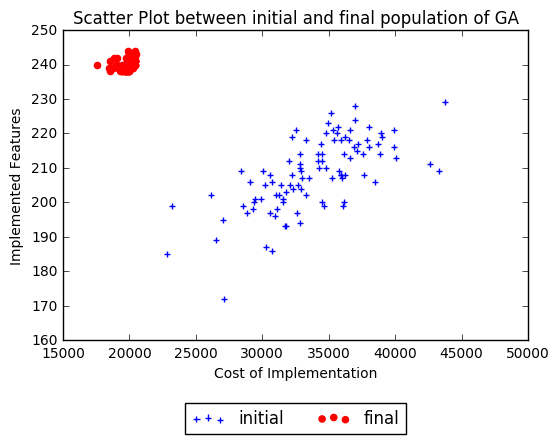

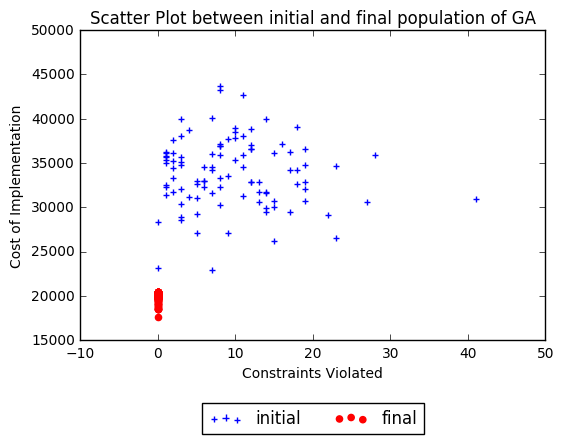

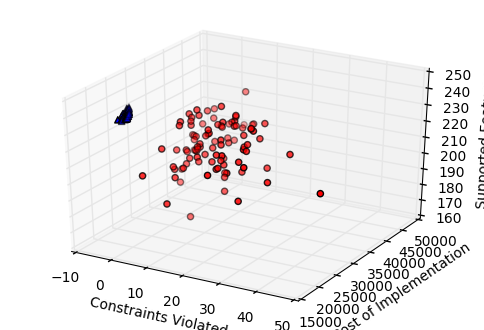

Running  nsga2
..................................................


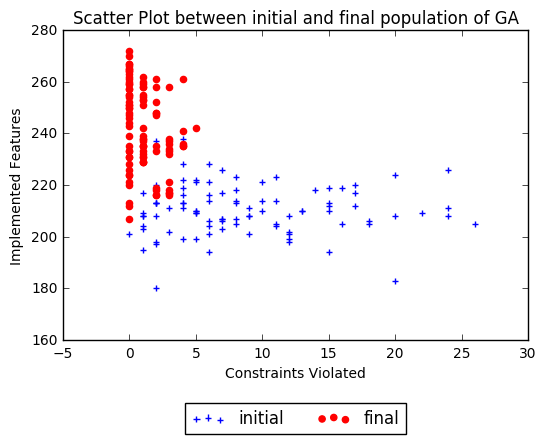

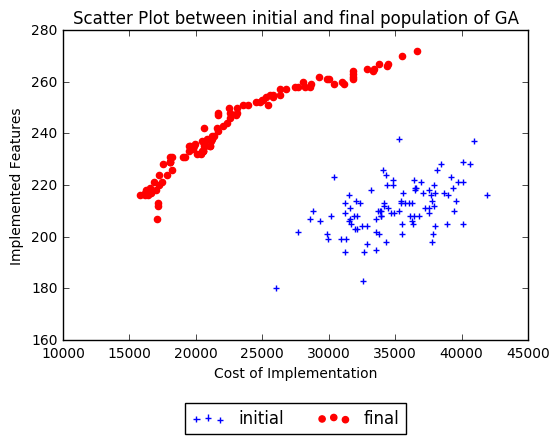

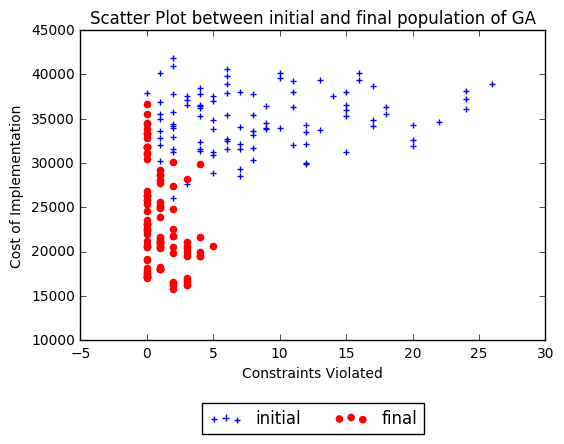

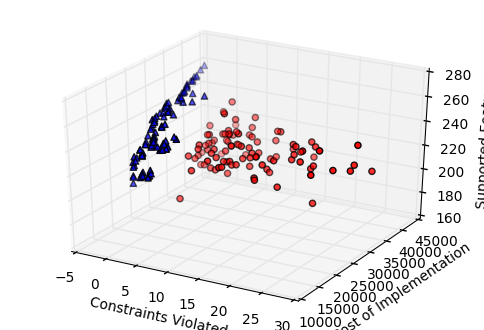

Running  ga
..................................................


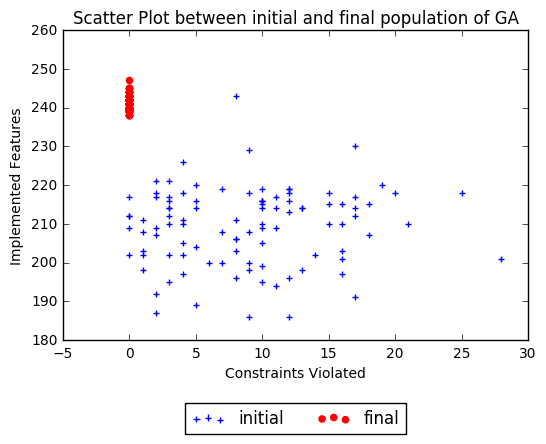

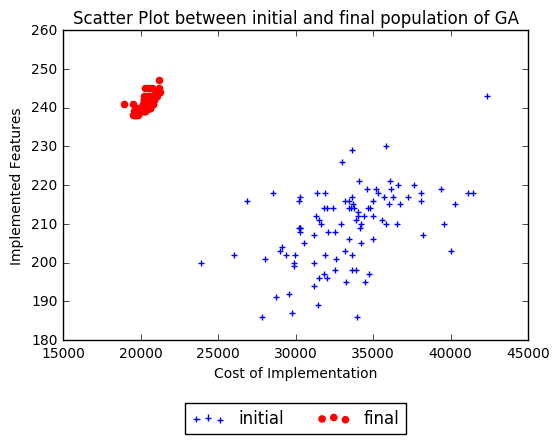

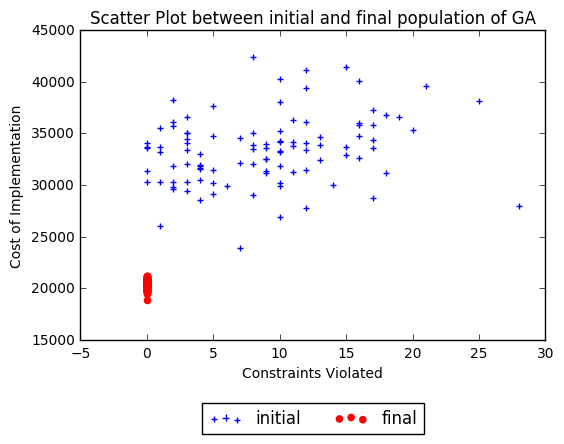

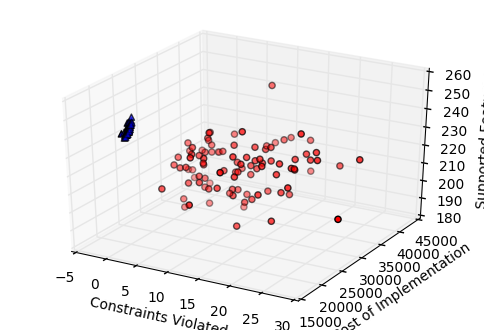

Running  nsga2
..................................................


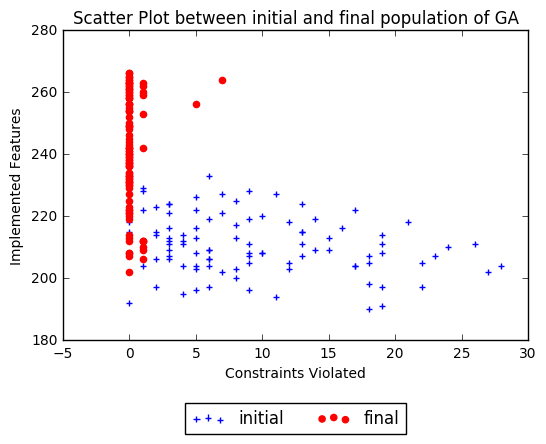

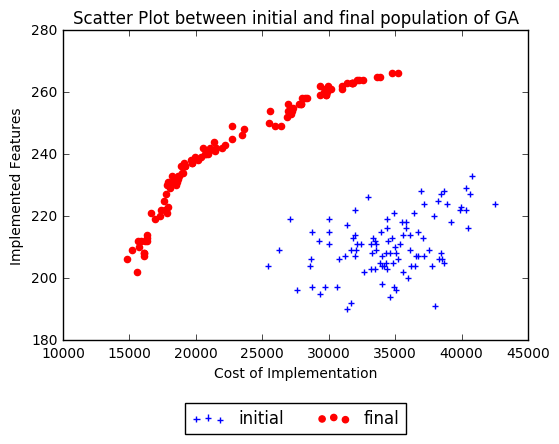

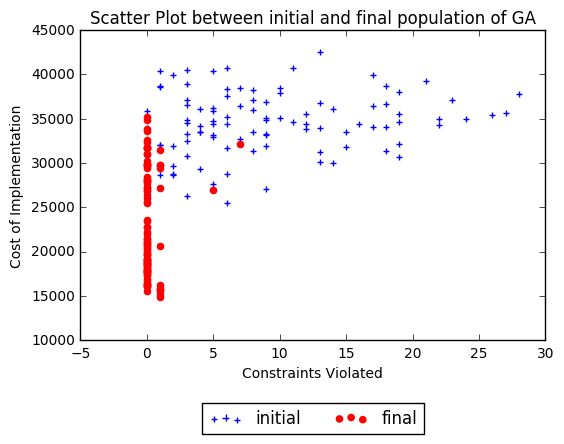

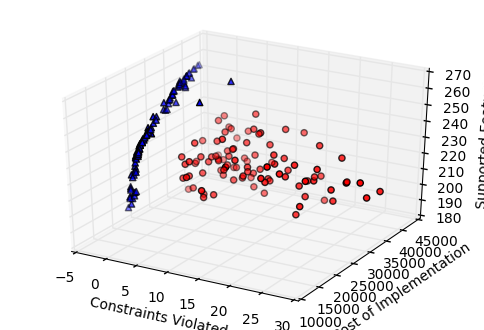

Running  ga
..................................................


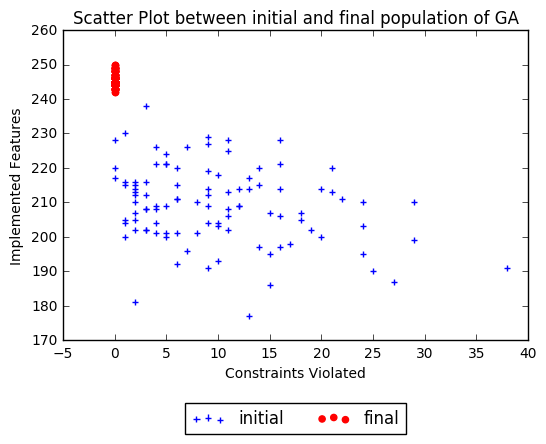

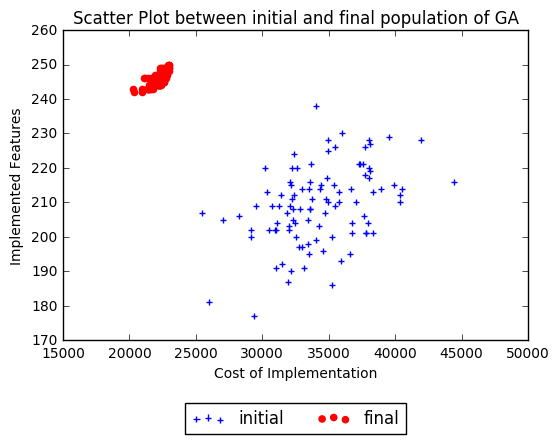

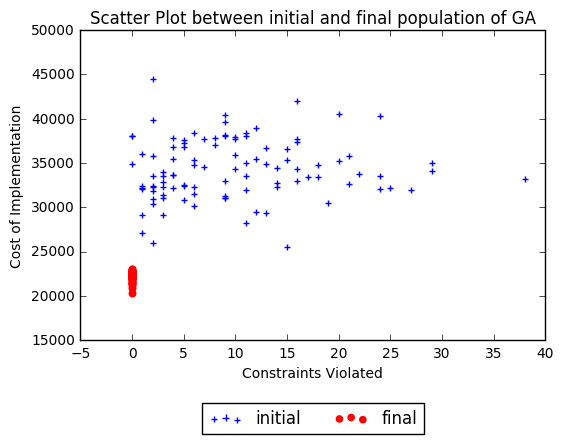

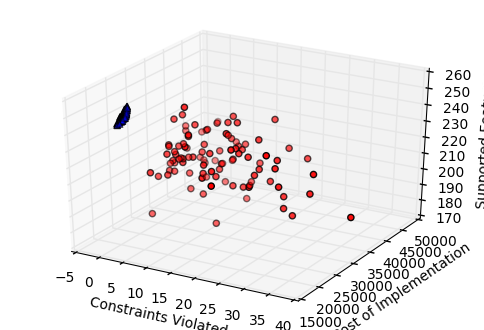

Running  nsga2
..................................................


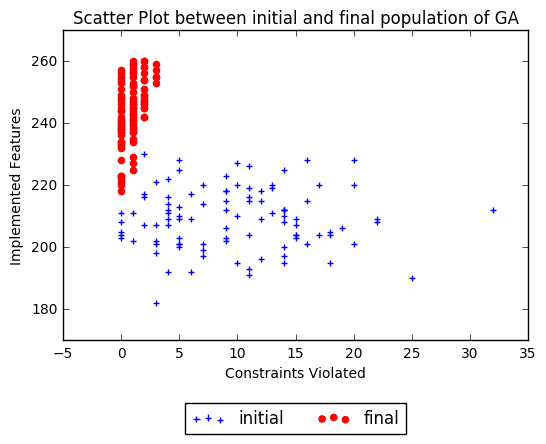

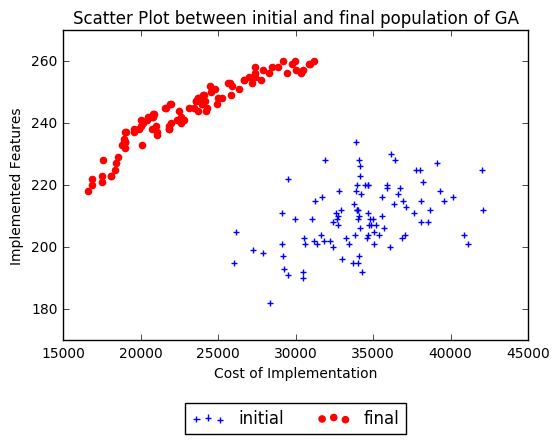

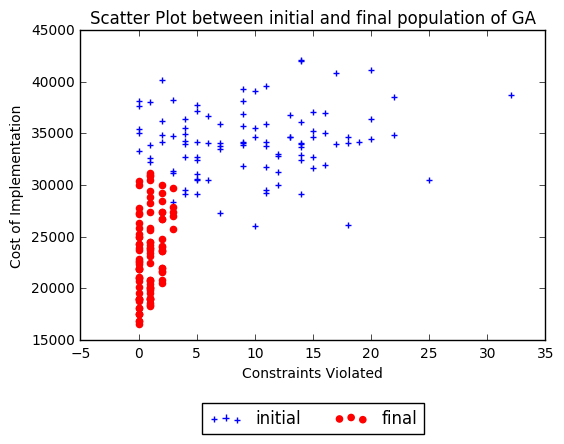

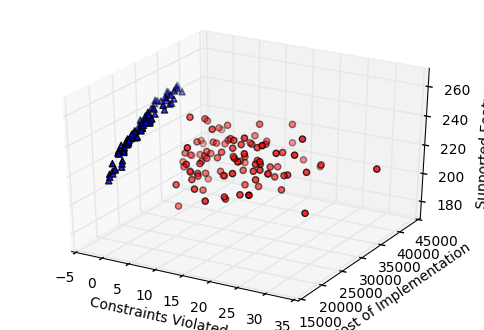

Running  ga
..................................................


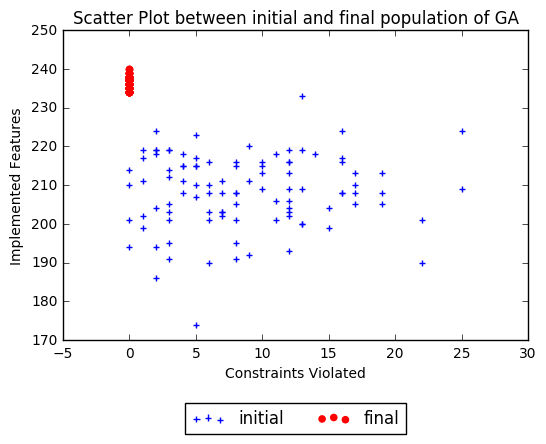

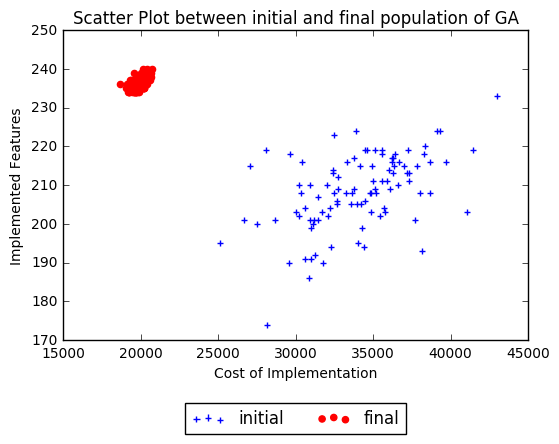

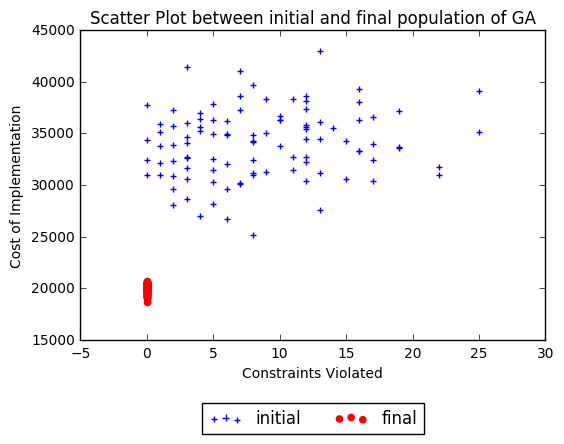

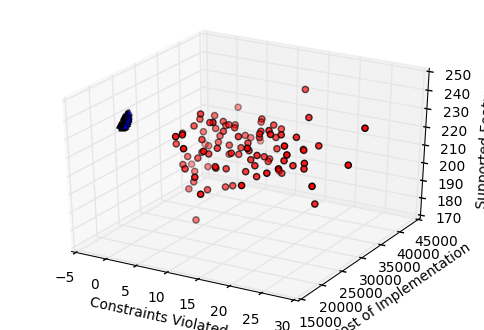

Running  nsga2
..................................................


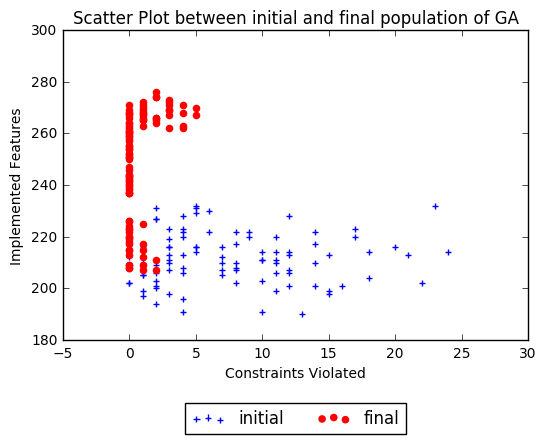

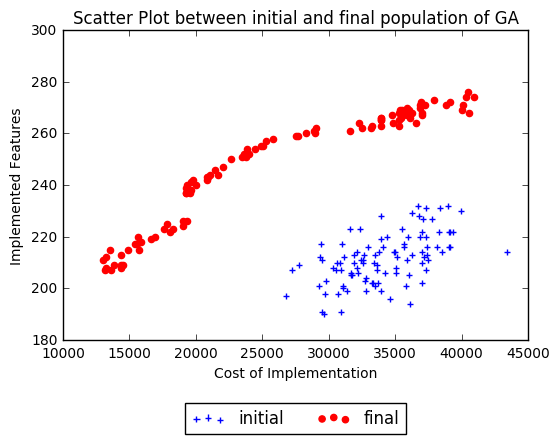

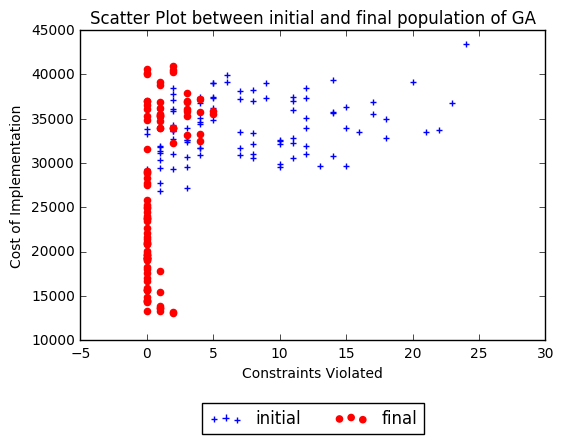

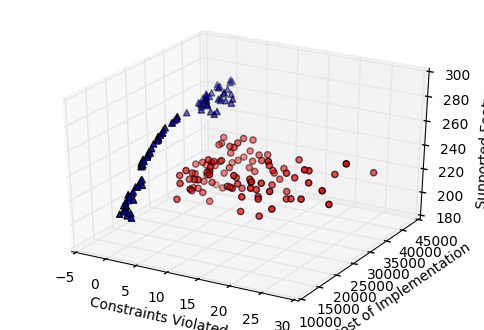

Running  ga
..................................................


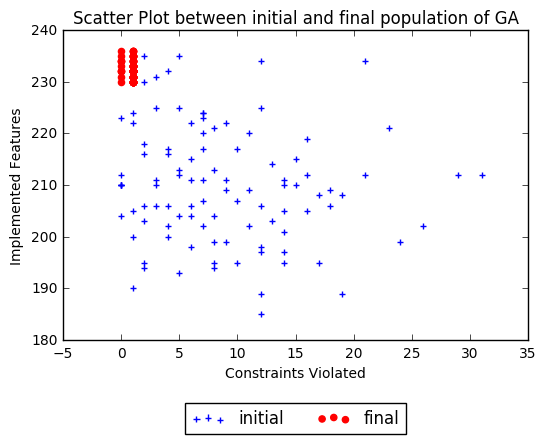

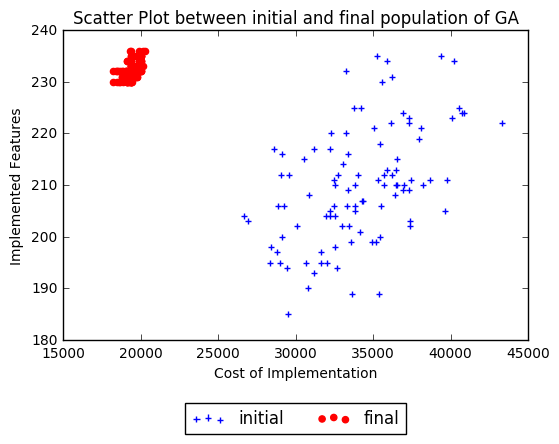

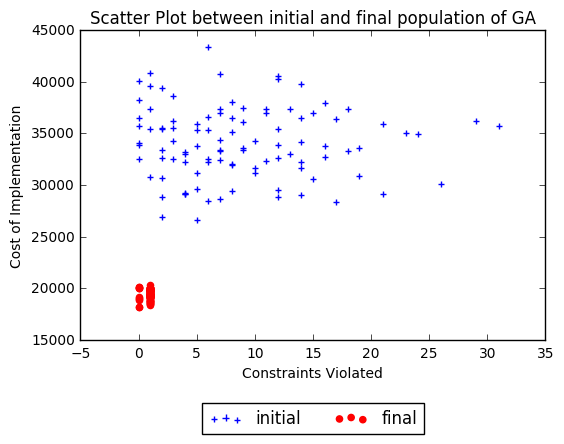

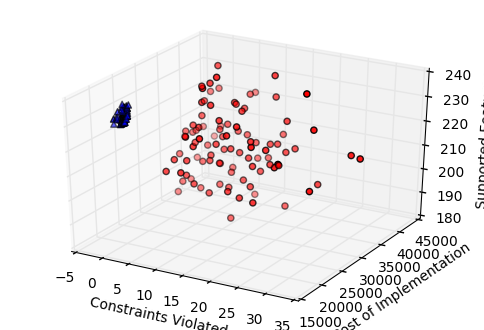

Running  nsga2
..................................................


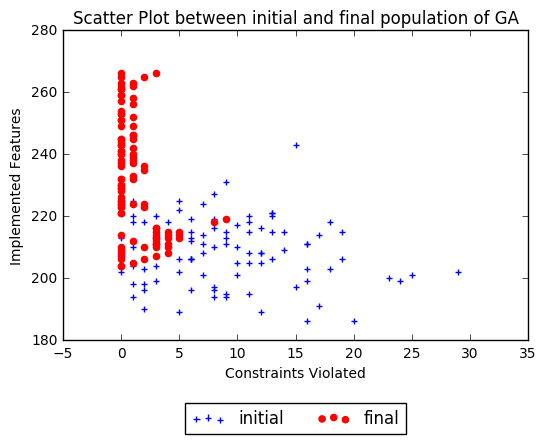

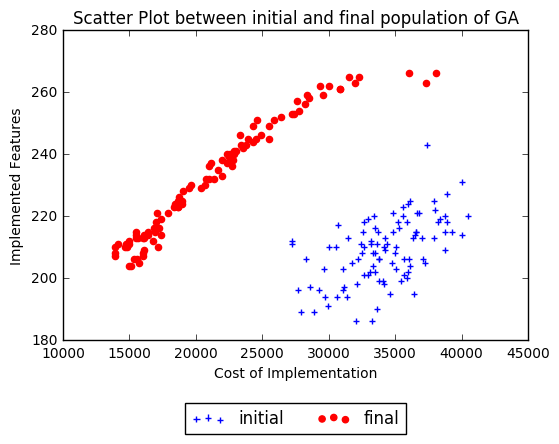

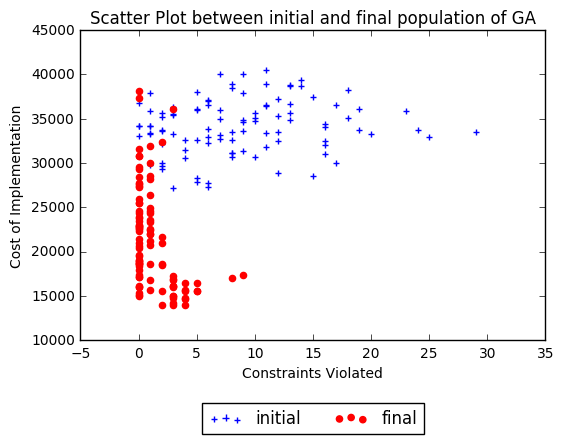

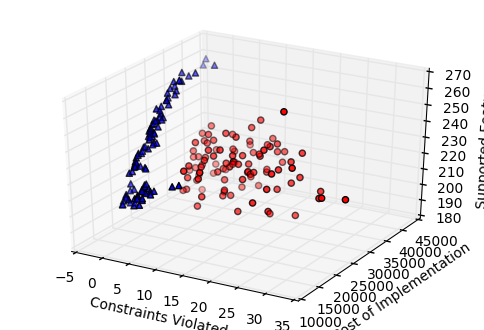

Running  ga
..................................................


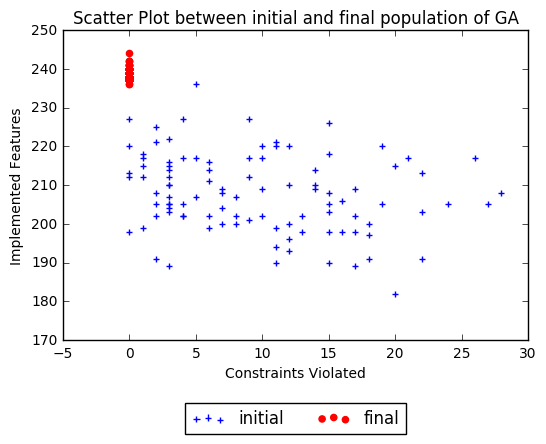

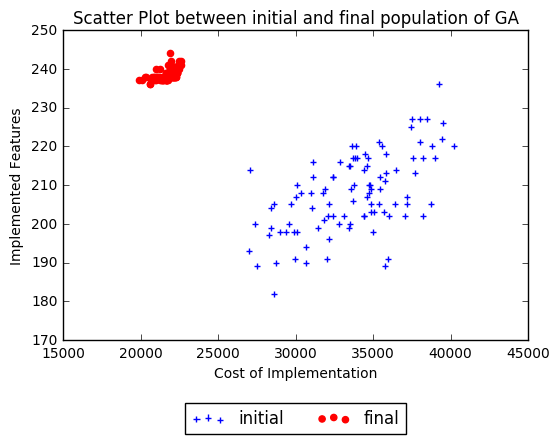

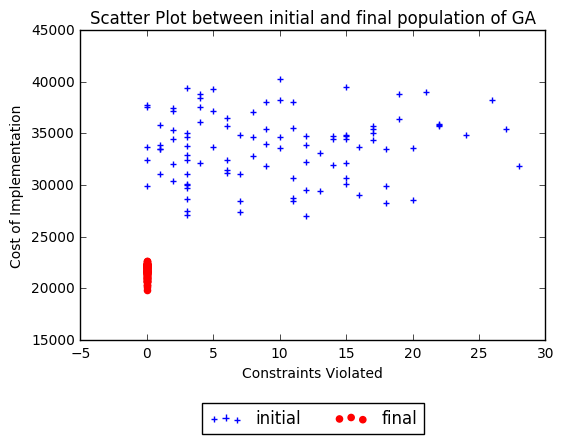

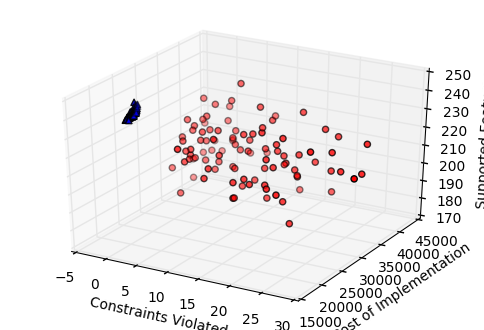

Running  nsga2
..................................................


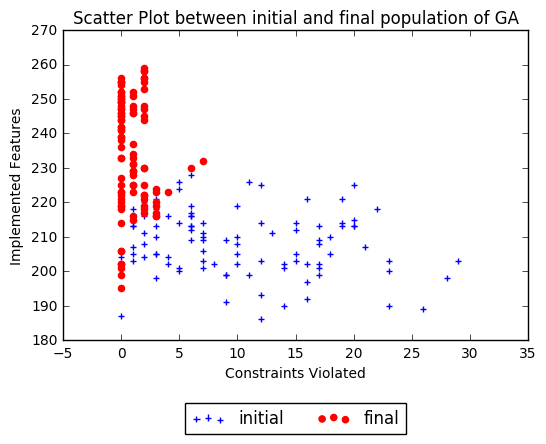

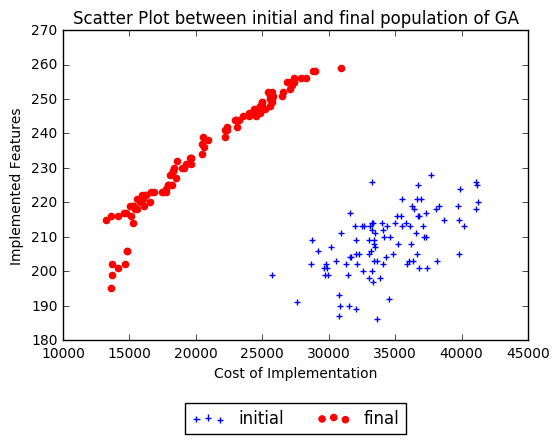

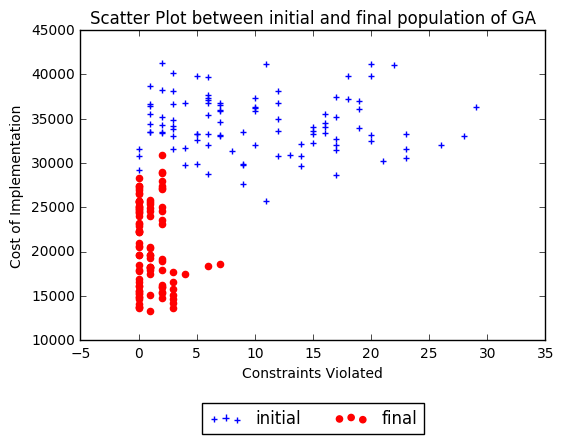

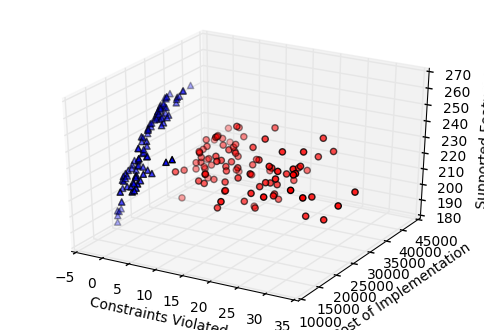

Running  ga
..................................................


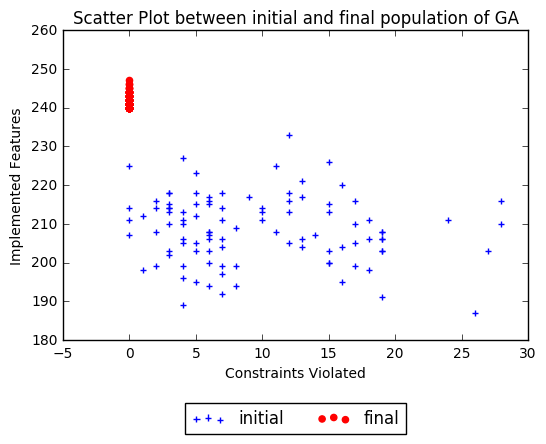

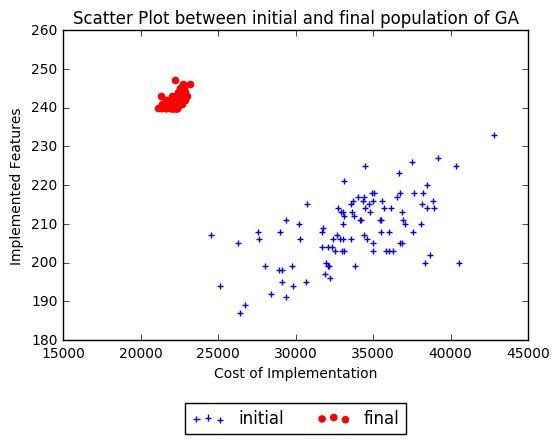

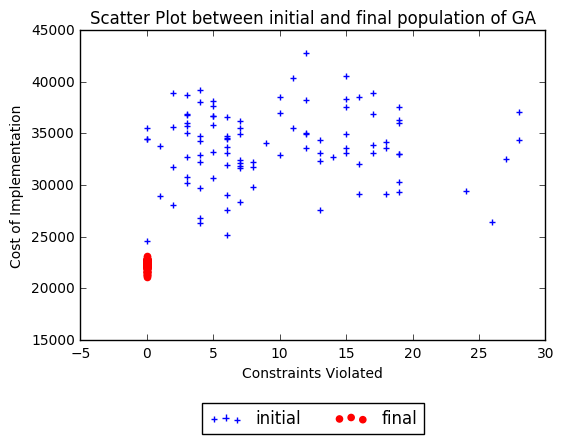

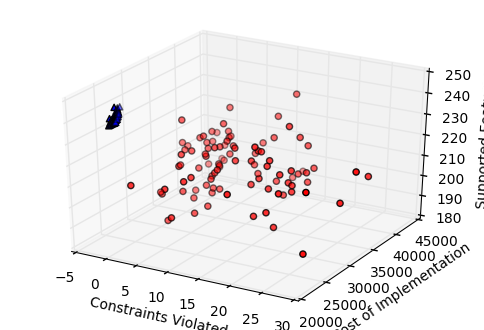

****************SPREAD****************
ga 1.01307796282
nsga2 0.840069939732

****************IGD****************
ga 0.00266583650678
nsga2 0.00853478667265
*** IGD ***
['nsga2', 'init', 'ga']

rank ,         name ,    med   ,  iqr 
----------------------------------------------------
   1 ,           ga ,    0   ,    0 (*-             |              ), 0.00,  0.00,  0.01,  0.01,  0.03
   1 ,        nsga2 ,    0   ,    0 (*              |              ), 0.01,  0.01,  0.01,  0.01,  0.01
   2 ,         init ,    0   ,    0 (             --|---  * ------ ), 0.19,  0.28,  0.31,  0.34,  0.43

*** Spread ***
['nsga2', 'init', 'ga']

rank ,         name ,    med   ,  iqr 
----------------------------------------------------
   1 ,         init ,    0   ,    0 (- *-           |              ), 0.57,  0.60,  0.61,  0.62,  0.65
   2 ,           ga ,    0   ,    0 (               | *   ----     ), 0.84,  0.86,  0.87,  0.95,  1.02
   2 ,        nsga2 ,    0   ,    0 (              -|   * --------

In [94]:
models = ['Linux.xml', 'Bike.xml', 'eCommerce.xml', 'bankingsw.xml',
          'billing.xml', 'car.xml', 'classicshell.xml', 'enterprisesys.xml', 'smarthome.xml']

#use this array in the end

algos = {'ga':ga, 'nsga2':nsga2}

#replace this with models after test
models_temp = ['enterprisesys.xml']


problems = [Problem(splot, 10000) for splot in models_temp]
for problem in problems:
    
    problem.details()
    tests = {t: [] for t in algos}
    tests['init']=[]#For initial population
    repeats = 10
    pop_size=100
    for _ in range(repeats):
        init_population = populate(problem, pop_size)
        for algo in algos:
            print('Running ',algo)
            initial, final = algos[algo](problem=problem, pop_size=pop_size, gens=50, dom_func=bdom)    
            plot_pareto(initial, final)
            plot_3D(initial, final)
            tests[algo].append(normalize(problem, final))
        tests['init'].append(normalize(problem, init_population))
    
    #print("Initial")
    #avg_and_variance(initial)
    #print("Final")
    #avg_and_variance(final)
    #print(tests)
    
    reference=make_reference(problem, tests['ga'][0], tests['nsga2'][0])
    #print(reference)
    print('****************SPREAD****************')
    print('ga', spread(tests['ga'][0], reference))
    print('nsga2',spread(tests['nsga2'][0], reference))
    print()
    print('****************IGD****************')
    print('ga', igd(tests['ga'][0], reference))
    print('nsga2', igd(tests['nsga2'][0], reference))
    
    print("*** IGD ***")
    report(problem, tests, igd)
    print("\n*** Spread ***")
    report(problem, tests, spread)
